In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
import sys
sys.path.append("..")

import numpy as np
import harmonix
from harmonix.harmonix import Harmonix, left_project, rTA1
from harmonix.solution import transform_to_zernike, solution_vector
import numpy as np

from jaxoplanet.experimental.starry import Map, Ylm, show_map

from zodiax import Base
from functools import partial

lm_to_n = lambda l,m : l**2+l+m
from harmonix.utils import csphjy
from jax import config
import matplotlib.pyplot as plt
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Simulating obervations of a star by CHARA using Harmonix


The van-Cittert Zernike theorem tells us there's a complex coherence function that can be calculated by taking the Fourier transform of the scene, or source intensity distribution on sky. In previous notebooks, we found that complex coherence function $\mathbf{V}$

$$\mathbf{V} = \mathrm{A} \mathbf{y}$$

where
$\mathrm{A}$ is $m\times n$, the design matrix \
$y \isin \mathbb{R}^n$, the spherical harmonic coefficient vector \
$V \isin \mathbb{C}^m$, the complex visibility vector

If our parameters are the spherical harmonic coefficients $\mathbf{y}$ of the map and our observations are of $\mathbf{V}$, then the entire problem is linear, and can be solved by a simple linear regression framework. The problem is that we never directly observe the complex coherence function, bit instead record any of several quantities such as the (calibrated) visibility amplitude, closure phase, or differential phase. To convert between the complex coherence function and some of these observables is not linear, so unfortunately the linearity of our problem is broken. Nevertheless, there are still ways of obtaining the Fisher information using autodifferentiation. 

In order to do this, we will construct a model and make a chi2 log likelihood based on the assumption of IID gaussian noise. Then, by taking the matrix of second derivatives of this likelihood function at the maximum likelihood point, we can estimate the Fisher information of our problem.

## Constructing the model:

In [2]:
ROTATIONAL_PHASES = 6
l_max = 8
UV_MAX = 8
nmax = lambda l_max: l_max**2 + 2 * l_max + 1

uu, vv = jnp.linspace(0.1,UV_MAX,8),jnp.linspace(0.1,UV_MAX,8)
u, v = jnp.meshgrid(uu, vv)
u = jnp.concatenate(u, axis=0)
v =  jnp.concatenate(v, axis=0)
inds = jnp.argsort(jnp.sqrt(u**2+v**2))
y = Ylm.from_dense(jnp.array([1.00,  0.22,  0.19,  0.11,  0.11,  0.07,  -0.11, 0.00,  -0.05, 
     0.12,  0.16,  -0.05, 0.06,  0.12,  0.05,  -0.10, 0.04,  -0.02, 
     0.01,  0.10,  0.08,  0.15,  0.13,  -0.11, -0.07, -0.14, 0.06, 
     -0.19, -0.02, 0.07,  -0.02, 0.07,  -0.01, -0.07, 0.04,  0.00]))
star = Map(y=y, inc=jnp.pi/2, obl=0, period=1.2, u=[0.1, 0.1])


Text(0.5, 1.0, 'Star map')

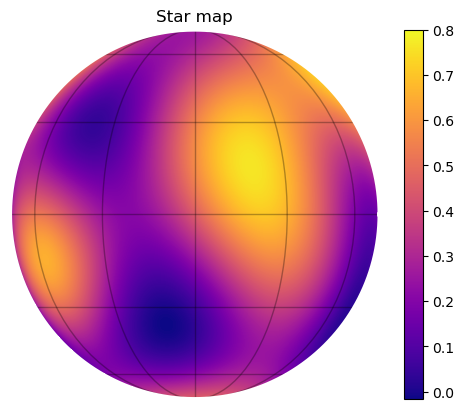

In [3]:
import numpy as np

from jaxoplanet.experimental.starry.maps import Map
from jaxoplanet.experimental.starry.utils import graticule
from jaxoplanet.experimental.starry.ylm import Ylm

def show_map(
    ylm_map_or_body,
    theta: float = 0.0,
    res: int = 400,
    n: int = 6,
    ax=None,
    white_contour: bool = True,
    **kwargs,
):
    """Show map of a

    Args:
        map_or_body (Map, Central or Body): Map or Body with a map
        theta (float, optional): Rotation angle of the map wrt its rotation axis.
        Defaults to 0.0.
        res (int, optional): Resolution of the map render. Defaults to 400.
        n (int, optional): number of latitude and longitude lines to show.
        Defaults to 6.
        ax (matplotlib.pyplot.Axes, optional): plot axes. Defaults to None.
        white_contour (bool, optional): Whether to surround the map by a white border
        (to hide border pixel aliasing). Defaults to True.
    """
    import matplotlib.pyplot as plt

    if ax is None:
        ax = plt.gca()
        if ax is None:
            ax = plt.subplot(111)

    if hasattr(ylm_map_or_body, "map"):
        map = ylm_map_or_body.map
        radius = ylm_map_or_body.radius.magnitude
        n = int(np.ceil(n * np.cbrt(radius)))
    # import Ylm leads to circular import
    elif isinstance(ylm_map_or_body, Ylm):
        map = Map(y=ylm_map_or_body)
        radius = 1.0
    else:
        map = ylm_map_or_body
        radius = 1.0

    res = ax.imshow(
        map.render(
            theta,
            res,
        ),
        origin="lower",
        **kwargs,
        extent=(-radius, radius, -radius, radius),
    )
    if n is not None:
        graticule(
            map.inc,
            map.obl,
            theta,
            radius=radius,
            n=n,
            white_contour=white_contour,
        )
    ax.axis(False)
    return res

res = show_map(star, vmax=0.8, cmap='plasma')
plt.colorbar(res)
plt.title("Star map")

In [4]:
from functools import partial
@partial(vmap, in_axes=(0, None, None, None))
@partial(vmap, in_axes=(1, None, None, None))
def cp_from_cvis(vis, index_cps1, index_cps2, index_cps3):
    '''
    Calculate closure phases [degrees] from complex visibilities and cp indices

    vis: complex visibilities
    index_cps1, index_cps2, index_cps3: indices for closure phases (e.g. [0,1,2] for 1st 3-baseline closure phase)

    Returns: closure phases [degrees]

    '''
    real = jnp.real(vis)
    imag = jnp.imag(vis)
    visphiall = jnp.arctan2(imag,real)
    visphiall = jnp.mod(visphiall + 10980., 360.)-180.
    visphi = jnp.reshape(visphiall,(len(vis),1))
    cp = visphi[jnp.array(index_cps1)] + visphi[jnp.array(index_cps2)] - visphi[jnp.array(index_cps3)]
    out = jnp.reshape(cp*180/np.pi,len(index_cps1))
    return out

def visibilities(harmonix_map, u, v, t):
    """Takes an array of u, v and times and returns the visibility amplitude where

    Args:
        harmonix_map (Harmonix): Harmonix map object
        u (jnp.array): N_baselines x N_samples array of u coordinates
        v (jnp.array): N_baselines x N_samples array of v coordinates
        t (float): (temporary) float of time t

    Returns:
        jnp.array: N_samples x N_baselines array of visibility amplitudes
    """
    vmap_model = vmap(vmap(harmonix_map.model, in_axes=(1, 1, None)), in_axes=(None, None, 0))
    return jnp.swapaxes(jnp.abs(vmap_model(u, v, t)),1,2)

def closure_phases(harmonix_map, u, v, t, index_cps1, index_cps2, index_cps3):
    """Takes an array of u, v and times and returns the closure phases

    Args:
        harmonix_map (Harmonix): Harmonix map object
        u (jnp.array): N_baselines x N_samples array of u coordinates
        v (jnp.array): N_baselines x N_samples array of v coordinates
        t (float): (temporary) float of time t
        index_cps1 (jnp.array): N_closure_phases array of indices
        index_cps2 (jnp.array): N_closure_phases array of indices
        index_cps3 (jnp.array): N_closure_phases array of indices

    Returns:
        jnp.array: N_samples x N_baselines array of complex visibilities
    """
    vmap_model = vmap(vmap(harmonix_map.model, in_axes=(1, 1, None)), in_axes=(None, None, 0))
    vis = jnp.swapaxes(vmap_model(u, v, t), 1,2)
    return jnp.swapaxes(cp_from_cvis(vis, index_cps1, index_cps2, index_cps3), 1,2)

# Creating fake CHARA observations:

## Simulating the UV tracks:

Here, I create code code to realistically simulate the UV tracks produced by the star Alioth on the second half of the night of March 22, 2024 with CHARA/SPICA (oddly specific but ok)

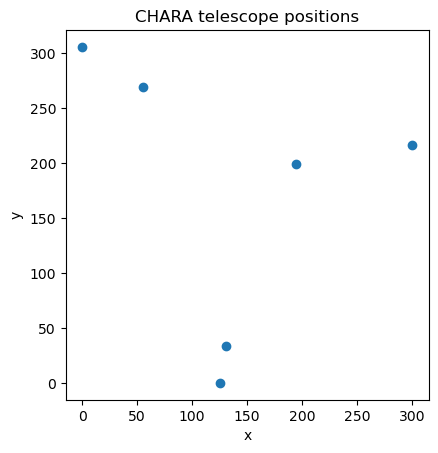

In [5]:

def maketriples_all(mask,verbose=False):
    """ returns int array of triple hole indices (0-based), 
        and float array of two uv vectors in all triangles
    """
    nholes = mask.shape[0]
    tlist = []
    for i in range(nholes):
        for j in range(nholes):
            for k in range(nholes):
                if i < j and j < k:
                    tlist.append((i, j, k))
    tarray = np.array(tlist).astype(np.int32)
    if verbose:
        print("tarray", tarray.shape, "\n", tarray)

    tname = []
    uvlist = []
    # foreach row of 3 elts...
    for triple in tarray:
        tname.append("{0:d}_{1:d}_{2:d}".format(
            triple[0], triple[1], triple[2]))
        if verbose:
            print('triple:', triple, tname[-1])
        uvlist.append((mask[triple[0]] - mask[triple[1]],
                       mask[triple[1]] - mask[triple[2]]))
    # print(len(uvlist), "uvlist", uvlist)
    if verbose:
        print(tarray.shape, np.array(uvlist).shape)
    return tarray, np.array(uvlist)

def makebaselines(mask):
    """
    ctrs_eqt (nh,2) in m
    returns np arrays of eg 21 baselinenames ('0_1',...), eg (21,2) baselinevectors (2-floats)
    in the same numbering as implaneia
    """
    nholes = mask.shape[0]
    blist = []
    for i in range(nholes):
        for j in range(nholes):
            if i < j:
                blist.append((i, j))
    barray = np.array(blist).astype(np.int32)
    # blname = []
    bllist = []
    for basepair in blist:
        # blname.append("{0:d}_{1:d}".format(basepair[0],basepair[1]))
        baseline = mask[basepair[0]] - mask[basepair[1]]
        bllist.append(baseline)
    return barray, np.array(bllist)

chara_tels = np.array(
    [[0, 0],
    [330.66,22.28],
    [-313.53,253.39],
    [302.33,25.7],
    [-221.82,241.27],
    [-65.88,236.6]])
#for some reason the file is rotated by 90 degrees
theta = -90
chara_tels[:,1] = chara_tels[:,1] + theta
station_x = chara_tels[:,0]*np.cos(np.radians(chara_tels[:,1]))
station_y = chara_tels[:,0]*np.sin(np.radians(chara_tels[:,1]))
station_x-=np.abs(station_x.min())
station_y+=np.abs(station_y.min())
plt.xlabel("x")
plt.ylabel("y")
plt.title("CHARA telescope positions")
plt.scatter(station_x, station_y)
plt.gca().set_aspect('equal', adjustable='box')

In [6]:
cp_inds, cp_uvs = maketriples_all(np.vstack([station_x, station_y]).T)[0:10]
baseline_inds, baselines = makebaselines(np.vstack([station_x, station_y]).T)

Now, let's get the hour angle and declination of a star, and use it to compute tracks in the UV plane due to Earth's rotation:

In [7]:
from skyfield.api import load
from skyfield.api import Star, load
from skyfield.data import hipparcos
from skyfield.api import N,S,E,W, wgs84

HOUR_ANGLES = 5
#using SPICA lowres
WAVS = 50

ts = load.timescale()
    
t =ts.utc(2023, 3, 23, np.linspace(8,12,HOUR_ANGLES))
planets = load('de421.bsp')
earth = planets['earth']

with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

chara = earth + wgs84.latlon(34.2249 * N, 118.0564 * W, elevation_m=1740)
alioth = Star.from_dataframe(df.loc[62956])
position = chara.at(t).observe(alioth).apparent()

ha, dec, distance = position.hadec()

#matrix to project a star's changing hour angle and declination onto the baselines
#to create uv tracks
proj_mat = []
for h, d in zip(ha.radians, dec.radians):
    proj_mat.append(np.array([[np.sin(h), np.cos(h), 0],
                  [-np.sin(d)*np.cos(h), np.sin(d)*np.sin(h), np.cos(d)],
                  [np.cos(d)*np.cos(h), -np.cos(d)*np.sin(h), np.sin(d)]]))
proj_mat = np.array(proj_mat)
proj_mat.shape

#project the baselines onto the uv plane
xyz = np.insert(baselines, 2, 0, axis=1)
wav = jnp.linspace(0.65*1e-6, 0.95*1e-6,WAVS)
uv = (proj_mat@xyz.T)[:,0:2]
#really complicated logic to first
#create a new axis for each wavelength
#then repeat the uv tracks for each wavelength
#then divide each uv track by the wavelength
#then transopse to get an array of (n_wavelengths, n_hourangles, 2, n_baselines)
uv_by_wav = (uv[np.newaxis,:,:].repeat(len(wav),axis=0).T/wav).T

(250, 15) (250, 15) (3750,)


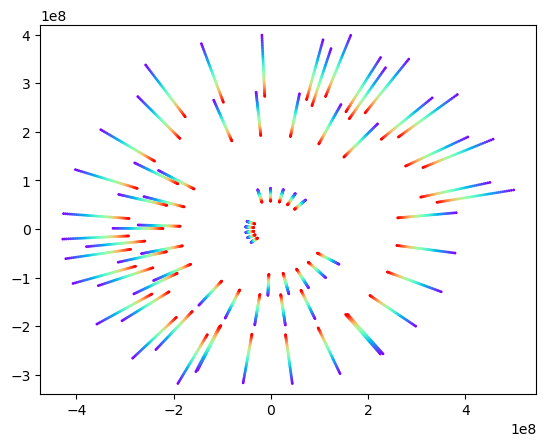

In [8]:
fig1, ax = plt.subplots()
ax.set_aspect("equal", adjustable="datalim")
u = np.concatenate(uv_by_wav[:,:,0],axis=0)
v = np.concatenate(uv_by_wav[:,:,1],axis=0)
wavs = wav.repeat(HOUR_ANGLES,axis=0).repeat(u.shape[1], axis=0)
print(u.shape, v.shape, wavs.shape)
plt.scatter(u,v,c=wavs,cmap='rainbow',s=1.);

## Simulating Alioth's complex visibilities:

In [9]:
ROTATIONAL_PHASES = 6
y_earth = jnp.array([1.00,  0.22,  0.19,  0.11,  0.11,  0.07,  -0.11, 0.00,  -0.05, 
     0.12,  0.16,  -0.05, 0.06,  0.12,  0.05,  -0.10, 0.04,  -0.02, 
     0.01,  0.10,  0.08,  0.15,  0.13,  -0.11, -0.07, -0.14, 0.06, 
     -0.19, -0.02, 0.07,  -0.02, 0.07,  -0.01, -0.07, 0.04,  0.00])

y = Ylm.from_dense(y_earth)
star = Map(y=y, inc=jnp.pi/2, obl=0, period=1.0, u=[0.1, 0.1])
star_interferometry = Harmonix(star)
cvis = jit(vmap(star_interferometry.model, in_axes=(1, 1, None)))

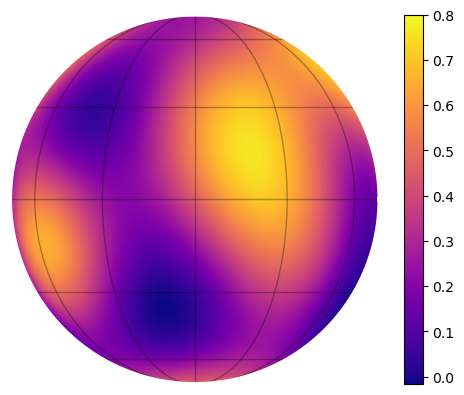

In [10]:
res = show_map(star, vmax=0.8, cmap='plasma')
plt.colorbar(res)

In [11]:
#convert from milliarcseconds to radians/pi for stellar diameter
#radians*pi because we'll multiply by pi anyways in the diameter formula
mas_to_rad = 1/(1000*60*60*180)*jnp.pi**2
complex_vis = cvis(1.47*mas_to_rad*jnp.array(u.T), 1.47*mas_to_rad*jnp.array(v.T),0.)

In [12]:
vis = visibilities(star_interferometry, 1.47*mas_to_rad*jnp.array(u.T), 1.47*mas_to_rad*jnp.array(v.T),jnp.array([0]))
cp = closure_phases(star_interferometry, 1.47*mas_to_rad*jnp.array(u.T), 1.47*mas_to_rad*jnp.array(v.T),jnp.array([0]), cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])

Text(0, 0.5, 'visibility amplitude')

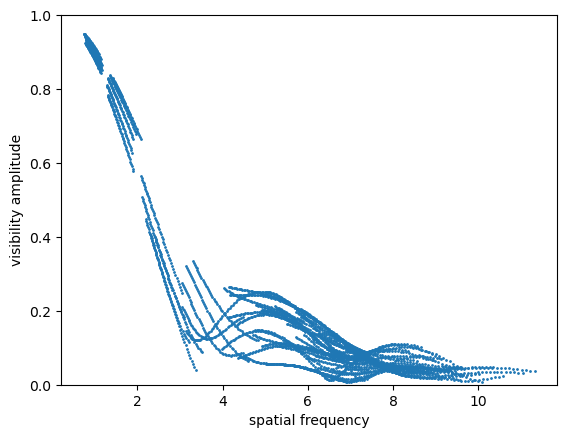

In [13]:
plt.scatter(jnp.sqrt((1.47*mas_to_rad*jnp.array(u.T))**2+(1.47*mas_to_rad*jnp.array(v.T))**2), vis, s=1);
plt.ylim([0,1])
plt.xlabel("spatial frequency")
plt.ylabel("visibility amplitude")

Text(0.5, 0, 'spatial frequency at max baseline')

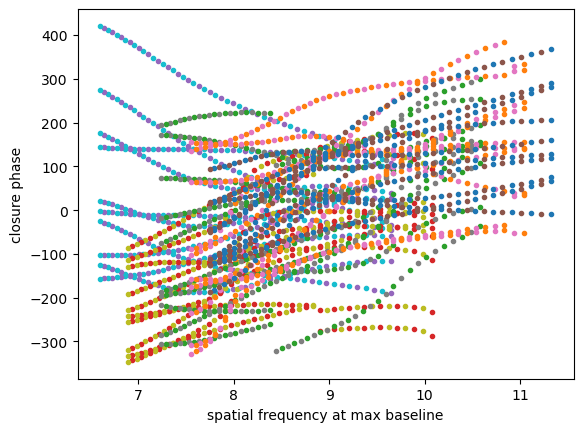

In [14]:
cp_x_axis = jnp.max(
    jnp.array([jnp.sqrt((1.47*mas_to_rad*jnp.array(u.T))**2+(1.47*mas_to_rad*jnp.array(v.T))**2)[cp_inds[0:10,0]],
    jnp.sqrt((1.47*mas_to_rad*jnp.array(u.T))**2+(1.47*mas_to_rad*jnp.array(v.T))**2)[cp_inds[0:10,1]],
    jnp.sqrt((1.47*mas_to_rad*jnp.array(u.T))**2+(1.47*mas_to_rad*jnp.array(v.T))**2)[cp_inds[0:10,2]]]), axis=0)
plt.plot(cp_x_axis, cp[0], '.');
plt.ylabel("closure phase")
plt.xlabel("spatial frequency at max baseline")

## Rotation synthesis null space:

In [15]:
lmax = 5
null_space_vis = {}
null_space_vis_cp = {}
for i, l in enumerate(range(lmax + 1)):
    for j, m in enumerate(range(-l, l + 1)):
        y_mode = jnp.zeros(nmax(lmax))
        y_mode = y_mode.at[0].set(1.0)
        y_mode = y_mode.at[lm_to_n(l, m)].set(1.0)
        y = Ylm.from_dense(y_mode)
        star = Map(y=y, inc=jnp.pi/2, obl=0, period=1.0, u=[0.1, 0.1])
        star_interferometry = Harmonix(star)
        vis = visibilities(star_interferometry, 1.47*mas_to_rad*jnp.array(u.T), 1.47*mas_to_rad*jnp.array(v.T),jnp.linspace(0,1,4))
        cp = closure_phases(star_interferometry, 1.47*mas_to_rad*jnp.array(u.T), 1.47*mas_to_rad*jnp.array(v.T),jnp.linspace(0,1,4), cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])
        if jnp.allclose(vis[0,:,:],vis[1,:,:],atol=1e-5) and jnp.allclose(vis[1,:,:],vis[2,:,:],atol=1e-5) and jnp.allclose(vis[2,:,:],vis[3,:,:],atol=1e-5):
            null_space_vis[(l, m)] = True
            if jnp.allclose(cp[0,:,:],cp[1,:,:],atol=1e-5) and jnp.allclose(cp[1,:,:],cp[2,:,:],atol=1e-5) and jnp.allclose(cp[2,:,:],cp[3,:,:],atol=1e-5):
                null_space_vis_cp[(l, m)] = True
            else:
                null_space_vis_cp[(l, m)] = False
        else:
            null_space_vis[(l, m)] = False
            null_space_vis_cp[(l, m)] = False
        

In [16]:
null_space_vis

{(0, 0): True,
 (1, -1): True,
 (1, 0): False,
 (1, 1): False,
 (2, -2): False,
 (2, -1): False,
 (2, 0): False,
 (2, 1): False,
 (2, 2): False,
 (3, -3): False,
 (3, -2): False,
 (3, -1): False,
 (3, 0): False,
 (3, 1): False,
 (3, 2): False,
 (3, 3): False,
 (4, -4): False,
 (4, -3): False,
 (4, -2): False,
 (4, -1): False,
 (4, 0): False,
 (4, 1): False,
 (4, 2): False,
 (4, 3): False,
 (4, 4): False,
 (5, -5): False,
 (5, -4): False,
 (5, -3): False,
 (5, -2): False,
 (5, -1): False,
 (5, 0): False,
 (5, 1): False,
 (5, 2): False,
 (5, 3): False,
 (5, 4): False,
 (5, 5): False}

In [17]:
null_space_vis_cp

{(0, 0): True,
 (1, -1): True,
 (1, 0): False,
 (1, 1): False,
 (2, -2): False,
 (2, -1): False,
 (2, 0): False,
 (2, 1): False,
 (2, 2): False,
 (3, -3): False,
 (3, -2): False,
 (3, -1): False,
 (3, 0): False,
 (3, 1): False,
 (3, 2): False,
 (3, 3): False,
 (4, -4): False,
 (4, -3): False,
 (4, -2): False,
 (4, -1): False,
 (4, 0): False,
 (4, 1): False,
 (4, 2): False,
 (4, 3): False,
 (4, 4): False,
 (5, -5): False,
 (5, -4): False,
 (5, -3): False,
 (5, -2): False,
 (5, -1): False,
 (5, 0): False,
 (5, 1): False,
 (5, 2): False,
 (5, 3): False,
 (5, 4): False,
 (5, 5): False}

## Likelihood function and covariances:


In [18]:
def loglike_visibility(model, data, noise, radius, u, v, t):
    """Log likelihood for visibility amplitude

    Args:
        model (Harmonix): Harmonix model
        radius (float): Radius of the star
        u (jnp.array): N_baselines x N_samples array of u coordinates
        v (jnp.array): N_baselines x N_samples array of v coordinates
        t (float): (temporary) float of time t

    Returns:
        jnp.array: N_samples x N_baselines array of visibility amplitudes
    """
    mas_to_rad = 1/(1000*60*60*180)*jnp.pi**2
    vis = visibilities(model, radius*mas_to_rad*u, radius*mas_to_rad*v, t)
    return -0.5 * jnp.sum((vis - data) ** 2 / noise ** 2)

def loglike_cp(model, data, noise, radius, u, v, t, index_cps1, index_cps2, index_cps3):
    """Log likelihood for visibility amplitude

    Args:
        model (Harmonix): Harmonix model
        radius (float): Radius of the star
        u (jnp.array): N_baselines x N_samples array of u coordinates
        v (jnp.array): N_baselines x N_samples array of v coordinates
        t (float): (temporary) float of time t

    Returns:
        jnp.array: N_samples x N_baselines array of visibility amplitudes
    """
    mas_to_rad = 1/(1000*60*60*180)*jnp.pi**2
    cp = closure_phases(model, radius*mas_to_rad*u, radius*mas_to_rad*v, t, index_cps1, index_cps2, index_cps3)
    return -0.5 * jnp.sum((cp - data) ** 2 / noise ** 2)

In [69]:
phases_dict = {}
#radius_dict = {}

Text(0, 0.5, 'visibility amplitude')

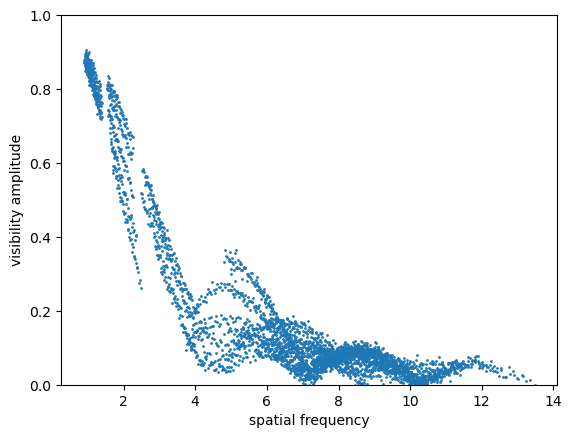

In [178]:
import zodiax as zdx
ROTATIONAL_PHASES = 6
y_earth = jnp.array([1.00,  0.22,  0.19,  0.11,  0.11,  0.07,  -0.11, 0.00,  -0.05, 
     0.12,  0.16,  -0.05, 0.06,  0.12,  0.05,  -0.10, 0.04,  -0.02, 
     0.01,  0.10,  0.08,  0.15,  0.13,  -0.11, -0.07, -0.14, 0.06, 
     -0.19, -0.02, 0.07,  -0.02, 0.07,  -0.01, -0.07, 0.04,  0.00])

y = Ylm.from_dense(y_earth)
star = Map(y=y, inc=jnp.pi/2, obl=0, period=1.0, u=[0.1, 0.1])
star_interferometry = Harmonix(star)
radius = 1.75
t = jnp.linspace(0,1,ROTATIONAL_PHASES, endpoint=False)
noise = 0.01
vis_data = visibilities(star_interferometry, radius*mas_to_rad*jnp.array(u.T), radius*mas_to_rad*jnp.array(v.T),t)
vis_data += jax.random.normal(jax.random.PRNGKey(0), vis_data.shape)*noise
cp_data = closure_phases(star_interferometry, radius*mas_to_rad*jnp.array(u.T), radius*mas_to_rad*jnp.array(v.T),t, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])
cp_data += jax.random.normal(jax.random.PRNGKey(0), cp_data.shape)*noise
plt.scatter(jnp.sqrt((radius*mas_to_rad*jnp.array(u.T))**2+(radius*mas_to_rad*jnp.array(v.T))**2), vis_data[4,:,:], s=1);
plt.ylim([0,1])
plt.xlabel("spatial frequency")
plt.ylabel("visibility amplitude")

Text(0, 0.5, 'visibility amplitude')

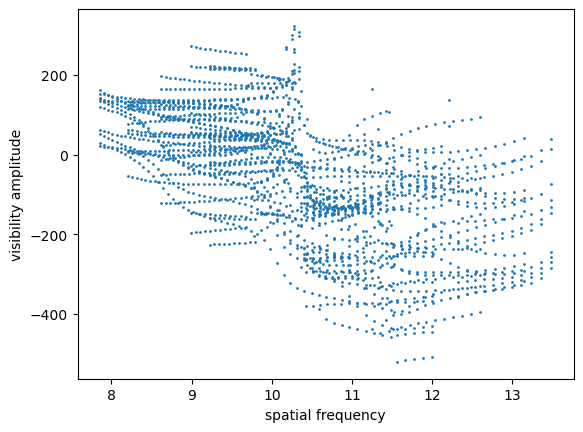

In [179]:
cp_x_axis = jnp.max(
    jnp.array([jnp.sqrt((radius*mas_to_rad*jnp.array(u.T))**2+(radius*mas_to_rad*jnp.array(v.T))**2)[cp_inds[0:10,0]],
    jnp.sqrt((radius*mas_to_rad*jnp.array(u.T))**2+(radius*mas_to_rad*jnp.array(v.T))**2)[cp_inds[0:10,1]],
    jnp.sqrt((radius*mas_to_rad*jnp.array(u.T))**2+(radius*mas_to_rad*jnp.array(v.T))**2)[cp_inds[0:10,2]]]), axis=0)
plt.scatter(cp_x_axis, cp_data[4,:,:], s=1);
plt.xlabel("spatial frequency")
plt.ylabel("visibility amplitude")

In [180]:
loglike_visibility(star_interferometry, vis_data, 0.01, radius, u.T, v.T,t)

Array(-11424.61479314, dtype=float64)

In [181]:
loglike_cp(star_interferometry, cp_data, 3.6, radius, u.T, v.T,t, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])

Array(-0.05818126, dtype=float64)

In [182]:
config.update("jax_debug_nans", False)
opt_params = ['data']
fim_vis = zdx.fisher_matrix(star_interferometry, opt_params,loglike_visibility, 
                            data=vis_data, radius=radius, 
                            u=u.T, v=v.T,t=t, noise=noise)

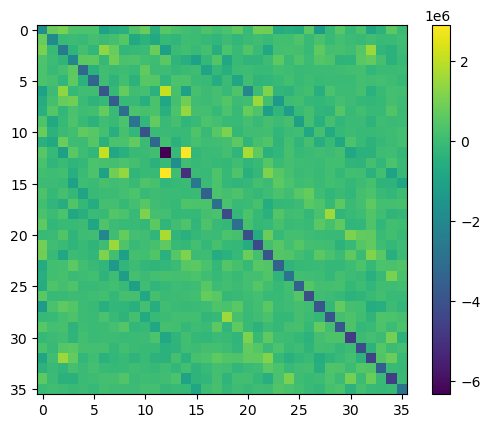

In [183]:
plt.imshow(fim_vis)
plt.colorbar()

In [184]:
fim_cp = zdx.fisher_matrix(star_interferometry, opt_params,loglike_cp, data=cp_data, radius=radius, u=u.T, v=v.T,t=t, noise=noise*360.,
                           index_cps1=cp_inds[0:10,0], index_cps2=cp_inds[0:10,1], index_cps3=cp_inds[0:10,2])

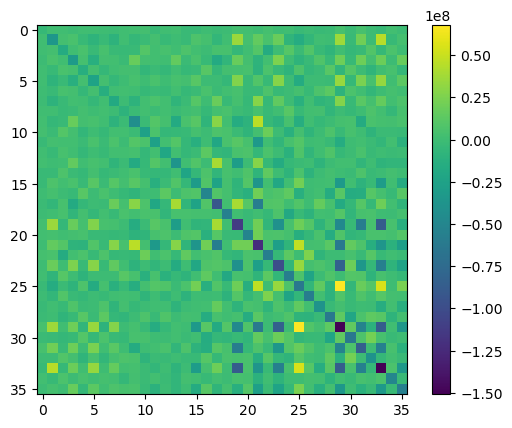

In [185]:
plt.imshow(fim_cp)
plt.colorbar()

Text(0.5, 0.98, 'Radius: 1.75')

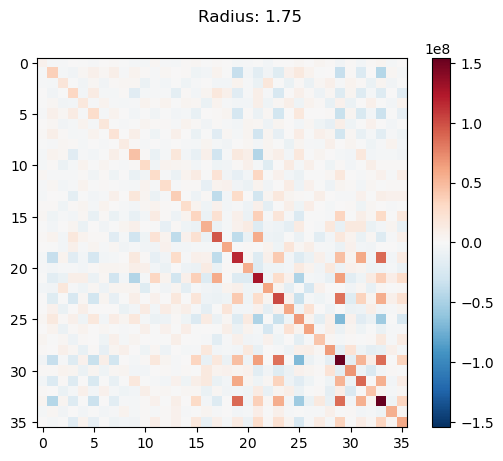

In [186]:
plt.imshow(-fim_cp-fim_vis,vmin=-jnp.max(-fim_cp-fim_vis),vmax=jnp.max(-fim_cp-fim_vis),  cmap='RdBu_r')
plt.colorbar()
plt.suptitle(f'Radius: {radius}')

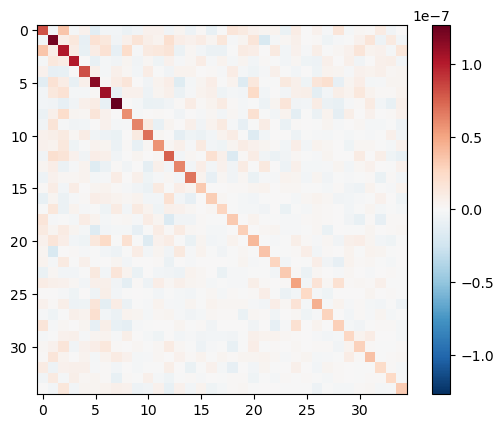

In [187]:
cov = -jnp.linalg.inv((fim_cp+fim_vis)[1:,1:])
plt.imshow(cov, cmap='RdBu_r',vmin=-jnp.max(cov),vmax=jnp.max(cov))
plt.colorbar()
#radius_dict[str(radius)]=cov
#plt.savefig(f'covariance_matrix_visibility_and_cp_chara_earth_{ROTATIONAL_PHASES}_phases.png',dpi=300)
#phases_dict[ROTATIONAL_PHASES] = cov

In [645]:
radius_dict.keys()

dict_keys(['0.5', '0.75', '1.0', '1.25', '1.5', '1.75', '2.0'])

In [651]:
covs = np.zeros((len(radius_dict),cov.shape[0]))
for index, (key, value) in enumerate(radius_dict.items()):
    covs[index,:] = jnp.sqrt(jnp.diag(value))

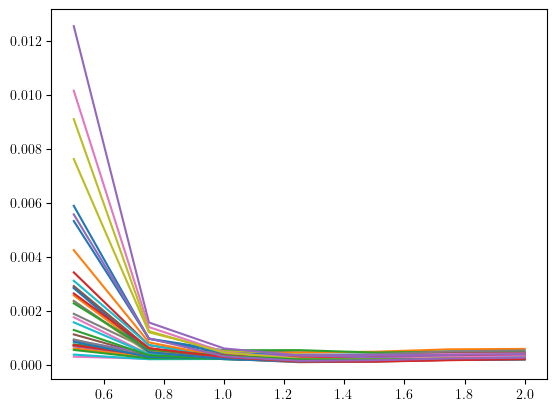

In [660]:
for i, v in enumerate(covs.T):
    plt.plot([float(i) for i in radius_dict.keys()], v);

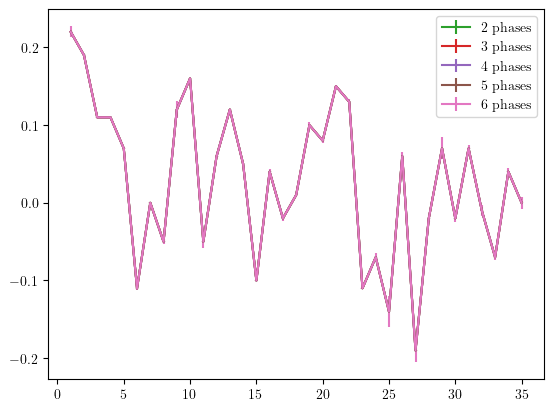

In [662]:
for key, value in phases_dict.items():
    if key !=1:
        plt.errorbar(jnp.arange(1,36), y_earth[1:], f'C{key}', label=f'{key} phases',)
plt.legend()

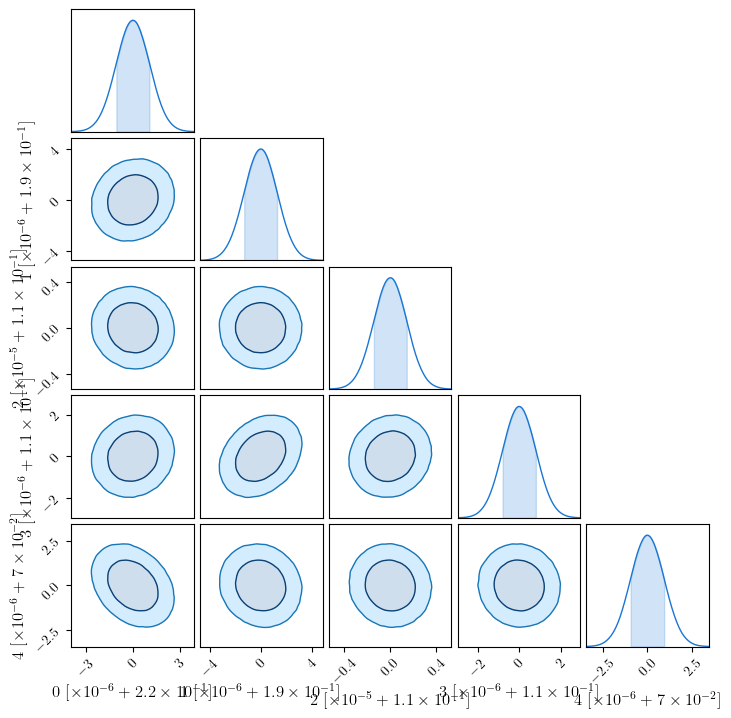

In [84]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_covariance(y_earth[1:6], cov[0:5,0:5])
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()

In [ ]:
def loglike_photometry(model, data, noise, t):
    